### Modules and constants

In [1]:
import os

%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from dafi.random_field import foam

from matplotlib import colors

VECTORDIM = 3
TENSORSQRTDIM = 3
TENSORDIM = 9
DEVSYMTENSORDIM = 6
DEVSYMTENSOR_INDEX = [0,1,2,4,5,8]

nscalar_invariants = 2
nbasis_tensors = 4

### Case specifics and plotting options

In [93]:
# tinit = 0
# tfinal = 100
da_step = 49 #48

data_dir = 'nnfoam_inputs/data'
nsamples = 20
results_dir = 'results_ensemble' 

mesh_shape = [50, 50]
flow = 0

scaleUx = 0.5
scaleUy = 500.0
scaleUz = 500.0

lim_option = 'same'  # ['different', 'same']
subfigsize = 3
cmap = 'Spectral'
save_figures = True
save_fig_dir = 'results_figures' 
fig_ext = 'png'
contour = False

### Physics functions

In [115]:
# get tensor basis T_ij
def get_tensor_basis(gradU, time_scale):
    ncells = len(time_scale)
    T = np.zeros([ncells, DEVSYMTENSORDIM, nbasis_tensors])
    for i, (igradU, it) in enumerate(zip(gradU, time_scale)):
        igradU = igradU.reshape([TENSORSQRTDIM, TENSORSQRTDIM])
        S = it * 0.5*(igradU + igradU.T)
        R = it * 0.5*(igradU - igradU.T)
        T1 = S
        T2 = S @ R - R @ S
        T3 = minus_thirdtrace(S @ S)
        T4 = minus_thirdtrace(R @ R)
        for j, iT in enumerate([T1, T2, T3, T4]):
            iT = iT.reshape([TENSORDIM])
            T[i, :, j] = iT[DEVSYMTENSOR_INDEX]
    return T


def minus_thirdtrace(x):
    return x - 1./3.*np.trace(x)*np.eye(TENSORSQRTDIM)


# shih_quadratic model: theta > g function
def shih_quadratic(theta):
    def g1(theta):
        num = -2./3.
        denom = 1.25 + np.sqrt(2 * theta[:, 0]) + 0.9 * np.sqrt(-2 * theta[:, 1])
        return num/denom

    def g234(theta, coeff):
        return coeff / (1000. + (2 * theta[:, 0])**(3./2.))

    g = np.empty([len(theta), nbasis_tensors])
    g[:, 0] = g1(theta)
    for i, c in enumerate([7.5, 1.5, -9.5]):
        g[:, i+1] = g234(theta, c)
    return g

# get b tensor basis
def get_b(g, gradU, time_scale):
    T = get_tensor_basis(gradU, time_scale)
    return _get_b(g, T)


def _get_b(g, T):
    return np.sum(np.expand_dims(g,1) * T, axis=-1)


def b2a(b, k):
    return 2 * np.expand_dims(np.squeeze(k), -1) * b


def a2Tau(a, tke):
    Tau = a.copy()
    Tau[:,0] += 2./3.*tke
    Tau[:,3] += 2./3.*tke
    Tau[:,5] += 2./3.*tke
    return Tau

def get_theta_tilde(gradU, time_scale):
    ncells = len(time_scale)
    theta_tilde = np.zeros([ncells, 2])
    theta = np.zeros([ncells, 2])
    for i, (igradU, it) in enumerate(zip(gradU, time_scale)):
        igradU = igradU.reshape([TENSORSQRTDIM, TENSORSQRTDIM])
        theta_tilde[i] = it**2 * 0.5 * (igradU[1,0]**2 + igradU[2,0]**2)
        S = it * 0.5*(igradU + igradU.T)
        S2 = S @ S
        theta[i, 0] = np.trace(S2)
        W = it * 0.5*(igradU - igradU.T)
        W2 = W @ W
        theta[i, 1] = np.trace(W2)
    return theta_tilde, theta

### Plotting functions

In [95]:
# plot component
def plot_comp(y, z, val, col_names, row_names, cmap='coolwarm', contour=False, lim_option='same', norm=True):
    Nrows = len(row_names)
    Ncols = len(col_names)
    lim = []
    if lim_option=='same':
        for i in range(Nrows):
            if norm:
                lim.append((min(-np.finfo(float).eps, np.min(val[-1][:, i])), max(np.finfo(float).eps, np.max(val[-1][:, i]))))
            else:
                lim.append((np.min(val[-1][:, i]), np.max(val[-1][:, i])))
    fig, axs = plt.subplots(Nrows, Ncols, figsize=((Ncols+0.5)*subfigsize, (Nrows+0.5)*subfigsize))
    for irow in range (Nrows):
        for icol in range(Ncols): 
            if contour:
                if lim_option=='same':
                    divnorm = colors.TwoSlopeNorm(vcenter=0, vmin=lim[irow][0], vmax=lim[irow][1])
                    cs = axs[irow, icol].contourf(rs(y), rs(z), rs(val[icol][:,irow]), cmap=cmap, vmin=lim[irow][0], vmax=lim[irow][1])
                elif lim_option=='different': 
                    cs = axs[irow, icol].contourf(rs(y), rs(z), rs(val[icol][:,irow]), cmap=cmap)
                    cbar = fig.colorbar(cs, ax=axs[irow, icol], shrink=0.95)
            else:
                if lim_option=='same':
                    if norm:
                        divnorm = colors.TwoSlopeNorm(vcenter=0, vmin=lim[irow][0], vmax=lim[irow][1])
                        cs = axs[irow,icol].pcolor(rs(y), rs(z), rs(val[icol][:,irow]), cmap=cmap, norm=divnorm, shading='auto')
                    else:
                        cs = axs[irow,icol].pcolor(rs(y), rs(z), rs(val[icol][:,irow]), cmap=cmap, vmin=lim[irow][0], vmax=lim[irow][1], shading='auto')
                elif lim_option=='different': 
                    cs = axs[irow,icol].pcolor(rs(y), rs(z), rs(val[icol][:,irow]), cmap=cmap, shading='auto') # norm=norm, shading='auto')
                    cbar = fig.colorbar(cs, ax=axs[irow, icol], shrink=0.75)
            plt.setp(axs[irow,icol].get_xticklabels(), visible=False)
            plt.setp(axs[irow,icol].get_yticklabels(), visible=False)
            axs[irow,icol].tick_params(axis='both', which='both', length=0)
            if icol==0:
                axs[irow,icol].set_ylabel(row_names[irow])
            if irow==0:
                axs[irow,icol].set_title(col_names[icol])
            axs[irow, icol].set_aspect('equal', 'box')
        if not contour and lim_option=='same':
            cbar = fig.colorbar(cs, ax=axs[irow], shrink=0.75)
    return fig, axs

# reshape the mesh
def rs(x):
    return x.reshape(mesh_shape)

# extract the sample mean
def extract_mean(field, step, dims):
    q_list = []
    for isamp in range(nsamples):
        if dims == 1:
            q = foam.read_scalar_field(results_dir + '/sample_{}/{}'.format(isamp, step) + '/' + field)
        elif dims == 3:
            q = foam.read_vector_field(results_dir + '/sample_{}/{}'.format(isamp, step) + '/' + field)
        elif dims == 6:
            q = foam.read_symmTensor_field(results_dir + '/sample_{}/{}'.format(isamp, step) + '/' + field)
        else:
            q = foam.read_tensor_field(results_dir + '/sample_{}/{}'.format(isamp, step) + '/' + field)
        q_list.append(q)
    q_mean = np.array(q_list).mean(axis=0)
    return q_mean


### Load data

In [96]:
# coordinates
x = np.loadtxt(os.path.join(data_dir, 'x'))
y = np.loadtxt(os.path.join(data_dir, 'y'))
z = np.loadtxt(os.path.join(data_dir, 'z'))
ncells = mesh_shape[0] * mesh_shape[1]

# initial
g1_mean = extract_mean('g1', 0, 1)
g2_mean = extract_mean('g2', 0, 1)
g3_mean = extract_mean('g3', 0, 1) # np.array(g3_list).mean(axis=0)
g4_mean = extract_mean('g4', 0, 1) # np.array(g4_list).mean(axis=0)
g_0 = np.vstack((g1_mean, g2_mean, g3_mean, g4_mean)).T #loadtxt(os.path.join(results_dir, da_step), f'g.{tinit}')) 
if nbasis_tensors==1:
    g_0 = np.expand_dims(np.squeeze(g_0), -1)

U_0 = extract_mean('U', 0, 3) # foam.read_vector_field(results_dir + '/sample_{}/{}'.format(isamp, da_step) + '/U')
gradU_0 = extract_mean('grad(U)', 0, 9) # foam.read_tensor_field(results_dir + '/sample_{}/{}'.format(isamp, da_step) + '/grad(U)')
time_scale_0 = extract_mean('timeScale', 0, 1)
tke_0 = extract_mean('k', 0, 1)
b_0 = get_b(g_0, gradU_0, time_scale_0)
a_0 = b2a(b_0, tke_0)
tau_0 = a2Tau(a_0, tke_0)
# W_0 = np.loadtxt(os.path.join(results_dir, f'w.{tinit}'))

# final
g1_mean = extract_mean('g1', da_step, 1)
g2_mean = extract_mean('g2', da_step, 1)
g3_mean = extract_mean('g3', da_step, 1)
g4_mean = extract_mean('g4', da_step, 1)
g_1 = np.vstack((g1_mean, g2_mean, g3_mean, g4_mean)).T
if nbasis_tensors==1:
    g_1 = np.expand_dims(np.squeeze(g_1), -1)

U_1 = extract_mean('U', da_step, 3)
gradU_1 = extract_mean('grad(U)', da_step, 9)
time_scale_1 = extract_mean('timeScale', da_step, 1)
tke_1 = extract_mean('k', da_step, 1)
b_1 = get_b(g_1, gradU_1, time_scale_1)
a_1 = b2a(b_1, tke_1)
tau_1 = a2Tau(a_1, tke_1)

U_t = foam.read_vector_field(data_dir + '/DNS_data/Re3500' + '/0/UDNS')
gradU_t = foam.read_tensor_field(data_dir + '/DNS_data/Re3500' + '/0/grad(U)')
T_t = get_tensor_basis(gradU_t, time_scale_1)

theta_t = np.load(os.path.join(data_dir, 'scalar_invariants.npy'))[:, :nscalar_invariants]
g_t = shih_quadratic(theta_t)

tke_t = np.load(os.path.join(data_dir, 'tke.npy'))
b_t = _get_b(g_t, T_t)
a_t = b2a(b_t, tke_t)

tau_t = foam.read_symmTensor_field(data_dir + '/DNS_data/Re3500' + '/0/TauDNS')


## $g$ functions

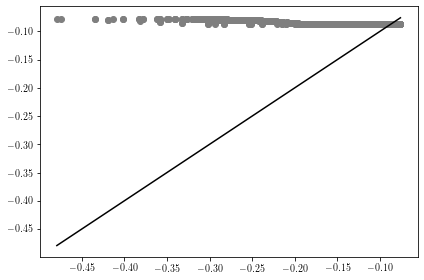

In [102]:
plt.figure()

plt.plot(g_t[:, 0], g_1[:, 0], 'o', color='tab:grey')
lim = [np.min(g_t[:, 0]), np.max(g_t[:, 0])]
plt.plot(lim, lim, 'k-')

# cross validation of $\theta$

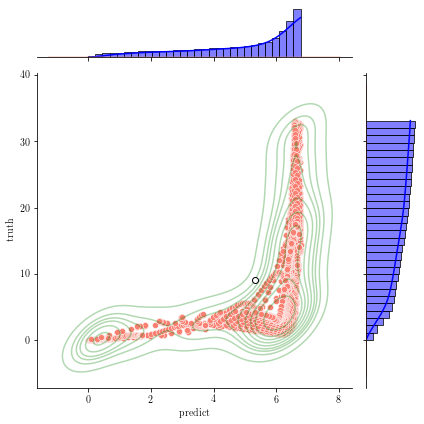

In [116]:
_, theta0 = get_theta_tilde(gradU_0, time_scale_0)
_, theta1 = get_theta_tilde(gradU_1, time_scale_1)
_, theta_t = get_theta_tilde(gradU_t, time_scale_1)

import pandas as pd
import seaborn as sns

posterior = np.zeros(theta_t.shape)
posterior[:, 0] = theta1[:, 0]
posterior[:, 1] = theta_t[:, 0]
posteriordf = pd.DataFrame(posterior, columns=["predict", "truth"])

g = sns.JointGrid(x="predict", y="truth", data=posteriordf, space=0)

g.plot_joint(sns.scatterplot, color='salmon')
g.plot_joint(sns.kdeplot, color='green', alpha=0.3)

g.plot_marginals(sns.histplot, kde=True, color="blue", bins=30, cumulative=True)

g.plot_marginals(sns.kdeplot, color="salmon", shade=False)
g.ax_joint.plot(posteriordf['predict'].mean(), posteriordf['truth'].mean(), 'o', markerfacecolor='w' ,markeredgecolor='k')

(<Figure size 756x540 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'Initial'}, ylabel='$g^{(1)}$'>,
         <AxesSubplot:title={'center':'Final'}>,
         <AxesSubplot:title={'center':'True'}>],
        [<AxesSubplot:ylabel='$g^{(2)} - 0.5g^{(3)} + 0.5g^{(4)}$'>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


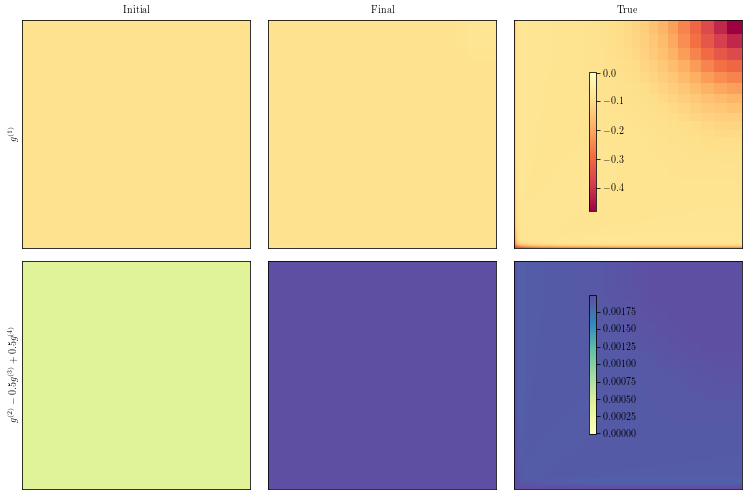

In [104]:
def g_inplane(g):
    return g[:, 1] - 0.5*g[:, 2] + 0.5*g[:, 3]

g_0n = np.zeros([ncells, 2])
g_0n[:, 0] = g_0[:, 0]
g_0n[:, 1] = g_inplane(g_0)

g_1n = np.zeros([ncells, 2])
g_1n[:, 0] = g_1[:, 0]
g_1n[:, 1] = g_inplane(g_1)

g_tn = np.zeros([ncells, 2])
g_tn[:, 0] = g_t[:, 0]
g_tn[:, 1] = g_inplane(g_t)

col_names = ['Initial', 'Final', 'True']
row_names = [r'$g^{(1)}$', r'$g^{(2)} - 0.5g^{(3)} + 0.5g^{(4)}$']
values = [g_0n, g_1n, g_tn]
lim_option = 'same'  # ['different', 'same']

plot_comp(y, z, values, col_names, row_names, cmap=cmap, contour=False, lim_option=lim_option, norm=True)

## Velocity

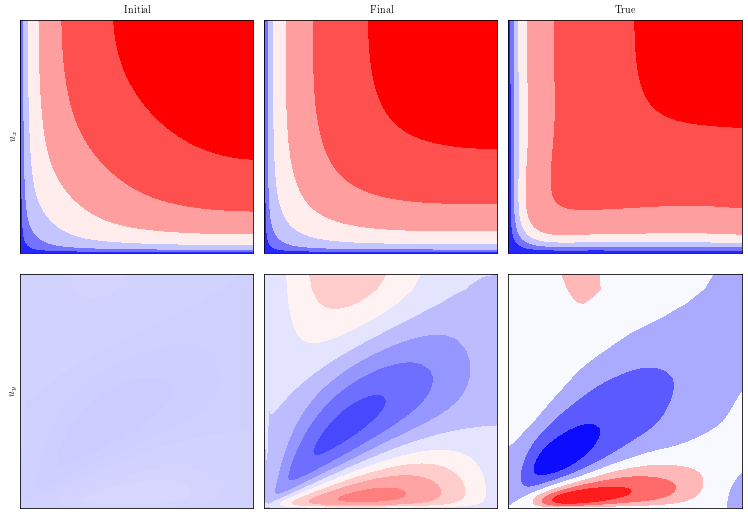

In [105]:
contour = True
cmap = 'bwr'
row_names = [r'$u_x$', r'$u_y$'] 
col_names = ['Initial', 'Final', 'True']
values = [U_0[:, :2], U_1[:, :2], U_t[:, :2]]
fig, axs = plot_comp(y, z, values, col_names, row_names, cmap=cmap, contour=contour, lim_option=lim_option, norm=1)

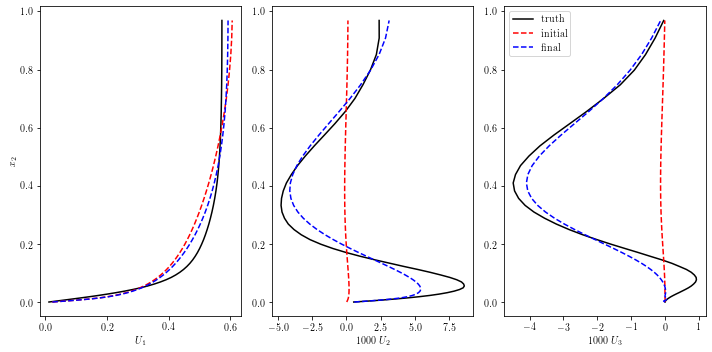

In [106]:
cellid = 36

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].plot(rs(U_t[:, 0]*scaleUx)[:,cellid], rs(y)[cellid, :], 'k-')
axs[0].plot(rs(U_0[:, 0]*scaleUx)[:,cellid], rs(y)[cellid, :], 'r--')
axs[0].plot(rs(U_1[:, 0]*scaleUx)[:,cellid], rs(y)[cellid, :], 'b--')
axs[0].set_ylabel('$x_2$')
axs[0].set_xlabel('$U_1$')


axs[1].plot(rs(U_t[:, 1]*scaleUy)[:,cellid], rs(y)[cellid, :], 'k-')
axs[1].plot(rs(U_0[:, 1]*scaleUy)[:,cellid], rs(y)[cellid, :], 'r--')
axs[1].plot(rs(U_1[:, 1]*scaleUy)[:,cellid], rs(y)[cellid, :], 'b--')
axs[1].set_xlabel('$1000~U_2$')

axs[2].plot(rs(U_t[:, 2]*scaleUz)[:,cellid], rs(y)[cellid, :], 'k-', label='truth')
axs[2].plot(rs(U_0[:, 2]*scaleUz)[:,cellid], rs(y)[cellid, :], 'r--', label='initial')
axs[2].plot(rs(U_1[:, 2]*scaleUz)[:,cellid], rs(y)[cellid, :], 'b--', label='final')
axs[2].set_xlabel('$1000~U_3$')
axs[2].legend()